# Run python script for wind field generation (will be put on pypi in following version)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
from scipy.special import gamma, factorial
import seaborn as sns
from matplotlib import rc
import scipy.stats as stats
import scipy  
import math
import scipy.special as sc
from scipy.special import gamma, factorial
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rc('font', family='serif')

In [3]:
run ../pyforwind/pyforwind.py

# Set the wind field box 

In [4]:
N_x = 1024 # grid points in "temporal" direction
N_y = N_z = 21 # rotor plane
N_xi = 30#30 # number of realization in Gaussian scale mixture 
dy = dz = 10. # resolution in rotor plane
y_i = z_i = -100. # lower left point of grid in rotor plane
y_e = z_e = 100. # upper right point of grid in rotor plane

# Model parameters

In [5]:
H = 1./3. # Hurst exponent, determines power law of Kaimal spectrum                                                                                                                                                 
mu = 0.22 # intermittency coefficient                                                                                                                                                                               
L = 340.2 # integral length scale in Kaimal spectrum                                                                                                                                                                
L_c = 340.2 # correlation length in Kaimal coherences                                                                                                                                                               
T = 600. # length of time series                                                                                                                                                                                    
tilde_T = 600.
V_hub = 8.
tilde_L = tilde_T*V_hub

# Generate Kaimal, Temporal Superstat. Kaimal, and Spatiotemporal Superstat. Kaimal wind fields with same seeds

In [6]:
swf = SWF(H, L, L_c, tilde_L, mu, dy, dz, y_i, y_e, z_i, z_e, T, tilde_T, N_x, N_y, N_z, N_xi, V_hub)
realizations = 1 # number of realizations
u_gauss = np.zeros((realizations, N_z, N_y, N_x))
u_temporal = np.zeros((realizations, N_z, N_y, N_x))
u_spatiotemporal = np.zeros((realizations, N_z, N_y, N_x))
for nn in range(realizations):
    seed = 12 
    u_gauss[nn] = swf.gauss_field(seed)
    u_temporal[nn], mask = swf.temporal_field(seed)
    u_spatiotemporal[nn], mask = swf.spatiotemporal_field(seed)
    seed += 1

/Users/jan/git/pyforwind/pyforwind/pyforwind.py:134: RuntimeWarning: divide by zero encountered in divide
  R_rescaled = np.where(self.R_ij==0, 0, np.array(xi**np.sqrt(self.mu*np.log(self.tilde_L/(self.R_ij)))*(self.R_ij/self.tilde_L)**(self.mu/2)*self.R_ij))
/Users/jan/git/pyforwind/pyforwind/pyforwind.py:134: RuntimeWarning: invalid value encountered in multiply
  R_rescaled = np.where(self.R_ij==0, 0, np.array(xi**np.sqrt(self.mu*np.log(self.tilde_L/(self.R_ij)))*(self.R_ij/self.tilde_L)**(self.mu/2)*self.R_ij))


# Plot slice of non-Gaussian and Gaussian wind fields

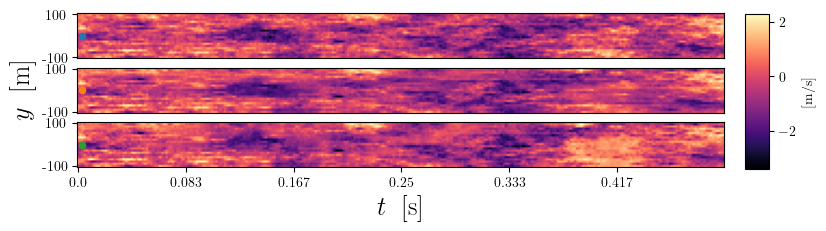

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,2))
length= 300
real = 0 # which realization to plot
yticks = np.array([0, 50, 100, 150, 200, 250])
zticks = np.linspace(0, length/600., length)
ax = axes.flat[0]
im = ax.imshow(u_gauss[real,8, :,:length], vmin=u_gauss[real,8,:,:length].min(), vmax=u_gauss[real,8,:,:length].max(),origin='lower', cmap='magma')
ax.set_xticks(yticks, np.round(yticks/600.,3))
ax.set_yticks([0,20], [-100,100])
ax.get_xaxis().set_visible(False)
ax.scatter(2,10, s=20, color='C0')
#plt.xlabel('$t\;\; \\textrm{[s]}$', fontsize=19)
ax = axes.flat[1]
im = ax.imshow(u_temporal[real,8, :,:length], vmin=u_gauss[real,8,:,:length].min(), vmax=u_gauss[real,8,:,:length].max(), origin='lower', cmap='magma')
ax.scatter(2,10, s=20, color='C1')
ax.set_xticks(yticks, np.round(yticks/600.,3))
ax.set_yticks([0,20], [-100,100])
ax.get_xaxis().set_visible(False)
ax.set_ylabel('$y\;\; \\textrm{[m]}$', fontsize=19)
ax = axes.flat[2]
im = ax.imshow(u_spatiotemporal[real,8, :,:length], vmin=u_gauss[real,8,:,:length].min(), vmax=u_gauss[real,8,:,:length].max(), origin='lower', cmap='magma')
ax.scatter(2,10, s=20, color='C2')
ax.set_xticks(yticks, np.round(yticks/600.,3))
ax.set_yticks([0,20], [-100,100])
ax.set_xlabel('$t\;\; \\textrm{[s]}$', fontsize=19)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.75, 0.102, 0.02, 0.775])
fig.colorbar(im, cax=cbar_ax, label='\\textrm{[m/s]}')
plt.rcParams["axes.grid"] = False
plt.savefig('superstat_kaimal.pdf', bbox_inches='tight')

Text(0.5, 0, '$t\\;\\; \\textrm{[s]}$')

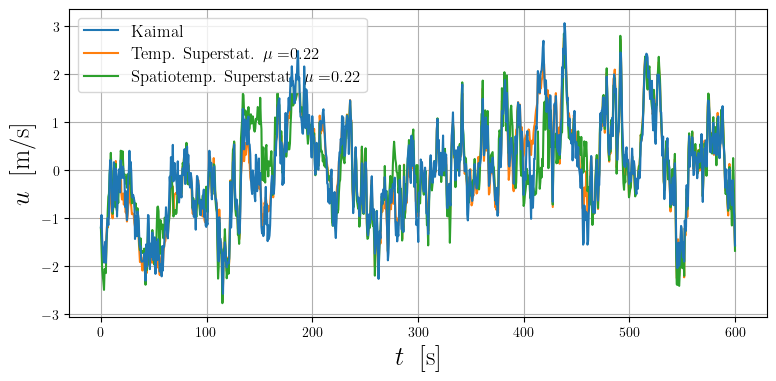

In [9]:
plt.rcParams["axes.grid"] = True
fig, ax = plt.subplots(figsize=(9, 4))
t = np.linspace(0, 600, N_x)
ax.plot(t, u_gauss[real,8,10,:], label='Kaimal', color='C0',zorder=12)
ax.plot(t, u_temporal[real,8,10, :], label='Temp. Superstat. $\\mu=$'+str(mu), color='C1')
ax.plot(t, u_spatiotemporal[real,8,10, :], label='Spatiotemp. Superstat. $\\mu=$'+str(mu), color='C2')
ax.legend(fontsize=12)
plt.ylabel('$u\;\; \\textrm{[m/s]}$', fontsize=19)
plt.xlabel('$t\;\; \\textrm{[s]}$', fontsize=19)

# Statistical quantities (structure functions, spectra)

In [10]:
tau = np.logspace(0.2, 2.5, 20, dtype='int')
print(tau)
struc_2_gauss = np.zeros(tau.size)
struc_4_gauss = np.zeros(tau.size)
struc_2_temporal = np.zeros(tau.size)
struc_4_temporal = np.zeros(tau.size)
struc_2_spatiotemporal = np.zeros(tau.size)
struc_4_spatiotemporal = np.zeros(tau.size)
for rr in range(tau.size):
    struc_2_gauss[rr] = np.mean((np.roll(u_gauss, tau[rr], axis=3)-u_gauss)**2)
    struc_4_gauss[rr] = np.mean((np.roll(u_gauss, tau[rr], axis=3)-u_gauss)**4)
    struc_2_temporal[rr] = np.mean((np.roll(u_temporal, tau[rr], axis=3)-u_temporal)**2)
    struc_4_temporal[rr] = np.mean((np.roll(u_temporal, tau[rr], axis=3)-u_temporal)**4)
    struc_2_spatiotemporal[rr] = np.mean((np.roll(u_spatiotemporal, tau[rr], axis=3)-u_spatiotemporal)**2)
    struc_4_spatiotemporal[rr] = np.mean((np.roll(u_spatiotemporal, tau[rr], axis=3)-u_spatiotemporal)**4)

[  1   2   2   3   4   6   8  11  14  19  25  34  44  59  78 103 137 181
 239 316]


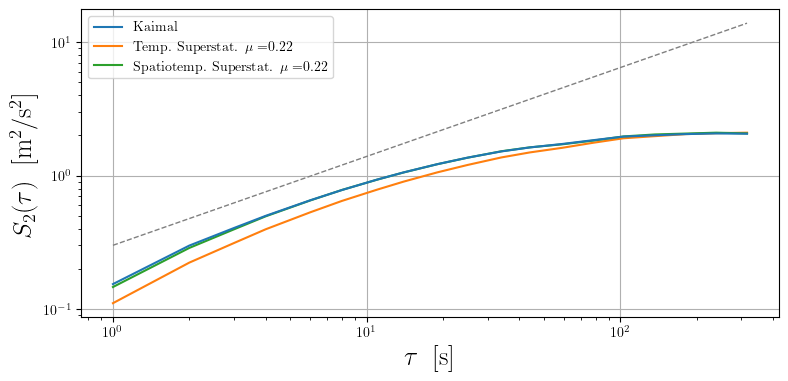

In [11]:
# second-order structure functions
plt.rcParams["axes.grid"] = True
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(tau, struc_2_gauss, label='Kaimal', color='C0',zorder=12)
ax.plot(tau, struc_2_temporal, label='Temp. Superstat. $\\mu=$'+str(mu), color='C1')
ax.plot(tau, struc_2_spatiotemporal, label='Spatiotemp. Superstat. $\\mu=$'+str(mu), color='C2')
ax.legend(fontsize=12)
plt.ylabel('$S_2(\\tau)\;\; \\textrm{[m$^2$/s$^2$]}$', fontsize=19)
plt.xlabel('$\\tau \;\; \\textrm{[s]}$', fontsize=19)
plt.loglog(tau, 0.3*tau**(2/3.), color='grey', ls='dashed', lw=1)
plt.legend()

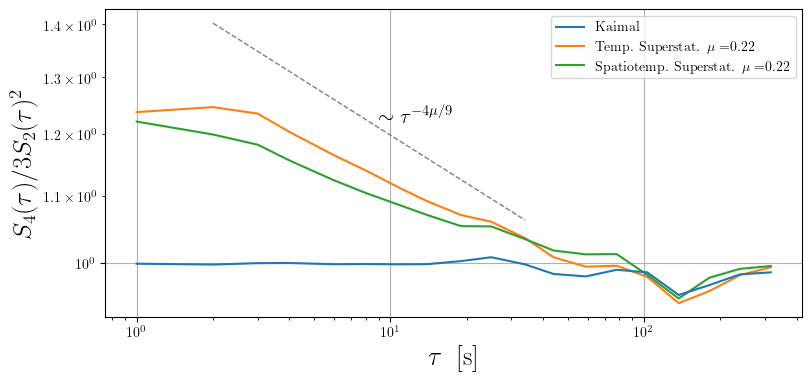

In [12]:
# flatness
plt.rcParams["axes.grid"] = True
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(tau, struc_4_gauss/(3.*struc_2_gauss**2), label='Kaimal', color='C0',zorder=12)
ax.plot(tau, struc_4_temporal/(3.*struc_2_temporal**2), label='Temp. Superstat. $\\mu=$'+str(mu), color='C1')
ax.plot(tau, struc_4_spatiotemporal/(3.*struc_2_spatiotemporal**2), label='Spatiotemp. Superstat. $\\mu=$'+str(mu), color='C2')
ax.legend(fontsize=12)
plt.ylabel('$S_4(\\tau)/3 S_2(\\tau)^2$', fontsize=19)
plt.xlabel('$\\tau \;\; \\textrm{[s]}$', fontsize=19)
plt.loglog(tau[1:-8], 1.5*tau[1:-8]**(-4.*mu/9.), color='grey', ls='dashed', lw=1)
ax.text(9, 1.22, '$\\sim \\tau^{-4\\mu/9}$', fontsize=15)
plt.legend()
#plt.loglog(R_struc,struc_4/(3.*struc_2**2), label='Superstat $\\mu=0.24$', color='C0')
#plt.loglog(R_struc,struc_4_gauss/(3.*struc_2_gauss**2), label='Kaimal', color='C2')
#plt.loglog(R_struc, 2*R_struc**(-4*mu/9), color='black', ls='dashed')
plt.legend()

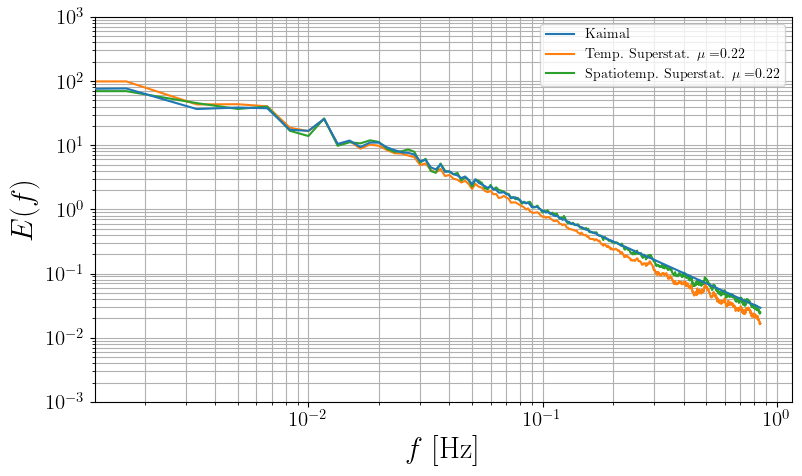

In [13]:
# spectra averaged over rotor plane
fig, ax = plt.subplots(figsize=(9, 5))
u_hat_gauss = np.fft.rfft(u_gauss, axis=3, norm='ortho')
u_hat_temporal = np.fft.rfft(u_temporal, axis=3, norm='ortho')
u_hat_spatiotemporal = np.fft.rfft(u_spatiotemporal, axis=3, norm='ortho')
spec_gauss = np.mean(np.abs(u_hat_gauss**2), axis=(0,1,2))
spec_temporal = np.mean(np.abs(u_hat_temporal**2), axis=(0,1,2))
spec_spatiotemporal = np.mean(np.abs(u_hat_spatiotemporal**2), axis=(0,1,2))
plt.ylim(10**(-3), 10**(3))
f = np.arange(N_x//2+1)/T
ax.plot(f[:-1], spec_gauss[:-1], label='Kaimal', color='C0',zorder=12)
ax.plot(f[:-1], spec_temporal[:-1], label='Temp. Superstat. $\\mu=$'+str(mu), color='C1')
ax.plot(f[:-1], spec_spatiotemporal[:-1], label='Spatiotemp. Superstat. $\\mu=$'+str(mu), color='C2')
#ax.plot(f[20:1000], k[20:1000]**(-5/3)*6000, color='grey', ls='dashed', lw=0.98)
ax.set_xscale('log')
ax.set_yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$f\; \\textrm{[Hz]}$', fontsize=22)
plt.ylabel('$E(f)$', fontsize=22)
#ax.text(150, 2.9, '$\\sim f^{-5/3}$', fontsize=15)
ax.legend(fontsize=14)
plt.grid(True, which='Both')
plt.legend()

# Generate increment PDFs

In [14]:
def inc_pdf(u_inst, R_PDF, bins, u_max):
    pdf_inc = np.zeros((R_PDF.size, bins))
    std_inc = np.zeros(R_PDF.size)
    for nn in range(u_inst.shape[0]):
        for rr in range(R_PDF.size):
            inc_x = np.roll(u_inst[nn],R_PDF[rr], axis=2)[:,:,R_PDF[rr]:]-u_inst[nn][:,:,R_PDF[rr]:]
            pdf_inst_x, edges = np.histogram(inc_x, bins=bins, range=[-u_max,u_max])
            pdf_inc[rr] += pdf_inst_x
            std_inc[rr] += np.std(inc_x)/realizations
    return std_inc, pdf_inc

In [21]:
bins = 256
R_PDF = np.array([2, 15, 100, 400])
u_max = 3.5
std_gauss, pdf_gauss = inc_pdf(u_gauss, R_PDF, bins, u_max)
pdf_gauss = np.ma.masked_where(pdf_gauss ==0, pdf_gauss)
std_temporal, pdf_temporal = inc_pdf(u_temporal, R_PDF, bins, u_max)
pdf_temporal = np.ma.masked_where(pdf_temporal ==0, pdf_temporal)
std_spatiotemporal, pdf_spatiotemporal = inc_pdf(u_spatiotemporal, R_PDF, bins, u_max)
pdf_spatiotemporal = np.ma.masked_where(pdf_spatiotemporal ==0, pdf_spatiotemporal)
v_neu = np.linspace(-u_max, u_max, bins)

(array([1.e-16, 1.e-14, 1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02,
        1.e+00, 1.e+02]),
 [Text(0, 1e-16, '$\\mathdefault{10^{-16}}$'),
  Text(0, 1e-14, '$\\mathdefault{10^{-14}}$'),
  Text(0, 1e-12, '$\\mathdefault{10^{-12}}$'),
  Text(0, 1e-10, '$\\mathdefault{10^{-10}}$'),
  Text(0, 1e-08, '$\\mathdefault{10^{-8}}$'),
  Text(0, 1e-06, '$\\mathdefault{10^{-6}}$'),
  Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$')])

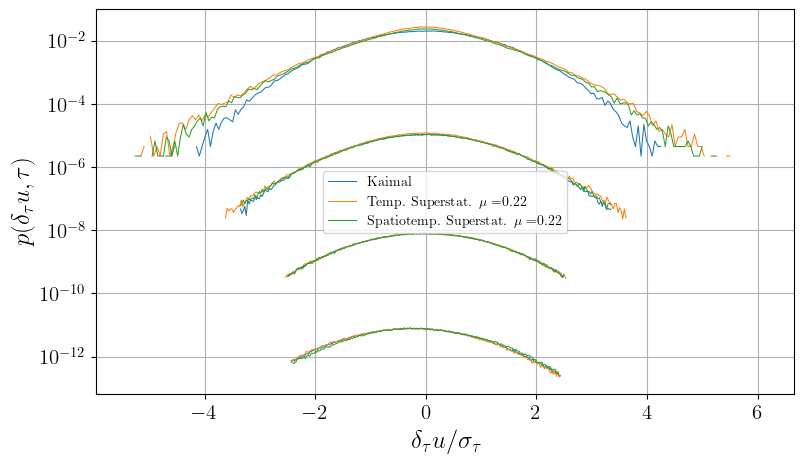

In [23]:
fig, ax = plt.subplots(figsize=(9, 5))
for rr in range(R_PDF.size-1):
    #r = R_PDF[rr]*T/N_x*V_hub/L
    ax.plot(v_neu/std_gauss[rr], pdf_gauss[rr]/np.sum(pdf_gauss[rr])*10**(-3*rr), lw = 0.75, color='C0')
    ax.plot(v_neu/std_temporal[rr], pdf_temporal[rr]/np.sum(pdf_temporal[rr])*10**(-3*rr), lw = 0.75, color='C1')
    ax.plot(v_neu/std_spatiotemporal[rr], pdf_spatiotemporal[rr]/np.sum(pdf_spatiotemporal[rr])*10**(-3*rr), lw = 0.75, color='C2')
ax.plot(v_neu/std_gauss[-1], pdf_gauss[-1]/np.sum(pdf_gauss[-1])*10**(-3*(R_PDF.size-1)), lw = 0.75, label='Kaimal', color='C0')
ax.plot(v_neu/std_temporal[-1], pdf_temporal[-1]/np.sum(pdf_temporal[-1])*10**(-3*(R_PDF.size-1)), lw = 0.75, label='Temp. Superstat. $\\mu=$'+str(mu), color='C1')
ax.plot(v_neu/std_spatiotemporal[-1], pdf_spatiotemporal[-1]/np.sum(pdf_spatiotemporal[-1])*10**(-3*(R_PDF.size-1)), lw = 0.75, label='Spatiotemp. Superstat. $\\mu=$'+str(mu), color='C2')
ax.set_yscale('log')
plt.xlabel('$\\delta_{\\tau} u/\\sigma_\\tau$', fontsize=18)
plt.ylabel('$p(\\delta_{\\tau} u, \\tau)$', fontsize=18)
ax.legend(frameon=True)
#label='$r= {0:.3f}$'.format(r)+'$L$',
plt.grid(True, which='Both')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)